**Возникновение дефолта** - заемщик прекращает вносить необходимые платежи по долгу

**Цель** - найти вероятность дефолта заемщика в процессе жизни кредита

# Requirements

In [ ]:
# !pip install numpy
# !pip install pandas
# !pip install sklearn
# !pip install xgboost
# !pip install matplotlib
# !pip install seaborn

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

# **Download data**

In [2]:
df = pd.read_csv('UCI_Credit_Card.csv').drop('ID', axis=1)
df = df.rename(columns={'default.payment.next.month': 'default'})
df

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0        20000.0    2          2         1   24      2      2     -1     -1   
1       120000.0    2          2         2   26     -1      2      0      0   
2        90000.0    2          2         2   34      0      0      0      0   
3        50000.0    2          2         1   37      0      0      0      0   
4        50000.0    1          2         1   57     -1      0     -1      0   
...          ...  ...        ...       ...  ...    ...    ...    ...    ...   
29995   220000.0    1          3         1   39      0      0      0      0   
29996   150000.0    1          3         2   43     -1     -1     -1     -1   
29997    30000.0    1          2         2   37      4      3      2     -1   
29998    80000.0    1          3         1   41      1     -1      0      0   
29999    50000.0    1          2         1   46      0      0      0      0   

       PAY_5  ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  \
0         -2  ...        0.0        0.0        0.0       0.0     689.0   
1          0  ...     3272.0     3455.0     3261.0       0.0    1000.0   
2          0  ...    14331.0    14948.0    15549.0    1518.0    1500.0   
3          0  ...    28314.0    28959.0    29547.0    2000.0    2019.0   
4          0  ...    20940.0    19146.0    19131.0    2000.0   36681.0   
...      ...  ...        ...        ...        ...       ...       ...   
29995      0  ...    88004.0    31237.0    15980.0    8500.0   20000.0   
29996      0  ...     8979.0     5190.0        0.0    1837.0    3526.0   
29997      0  ...    20878.0    20582.0    19357.0       0.0       0.0   
29998      0  ...    52774.0    11855.0    48944.0   85900.0    3409.0   
29999      0  ...    36535.0    32428.0    15313.0    2078.0    1800.0   

       PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  default  
0           0.0       0.0       0.0       0.0        1  
1        1000.0    1000.0       0.0    2000.0        1  
2        1000.0    1000.0    1000.0    5000.0        0  
3        1200.0    1100.0    1069.0    1000.0        0  
4       10000.0    9000.0     689.0     679.0        0  
...         ...       ...       ...       ...      ...  
29995    5003.0    3047.0    5000.0    1000.0        0  
29996    8998.0     129.0       0.0       0.0        0  
29997   22000.0    4200.0    2000.0    3100.0        1  
29998    1178.0    1926.0   52964.0    1804.0        1  
29999    1430.0    1000.0    1000.0    1000.0        1  

[30000 rows x 24 columns]

# Feature Analysis

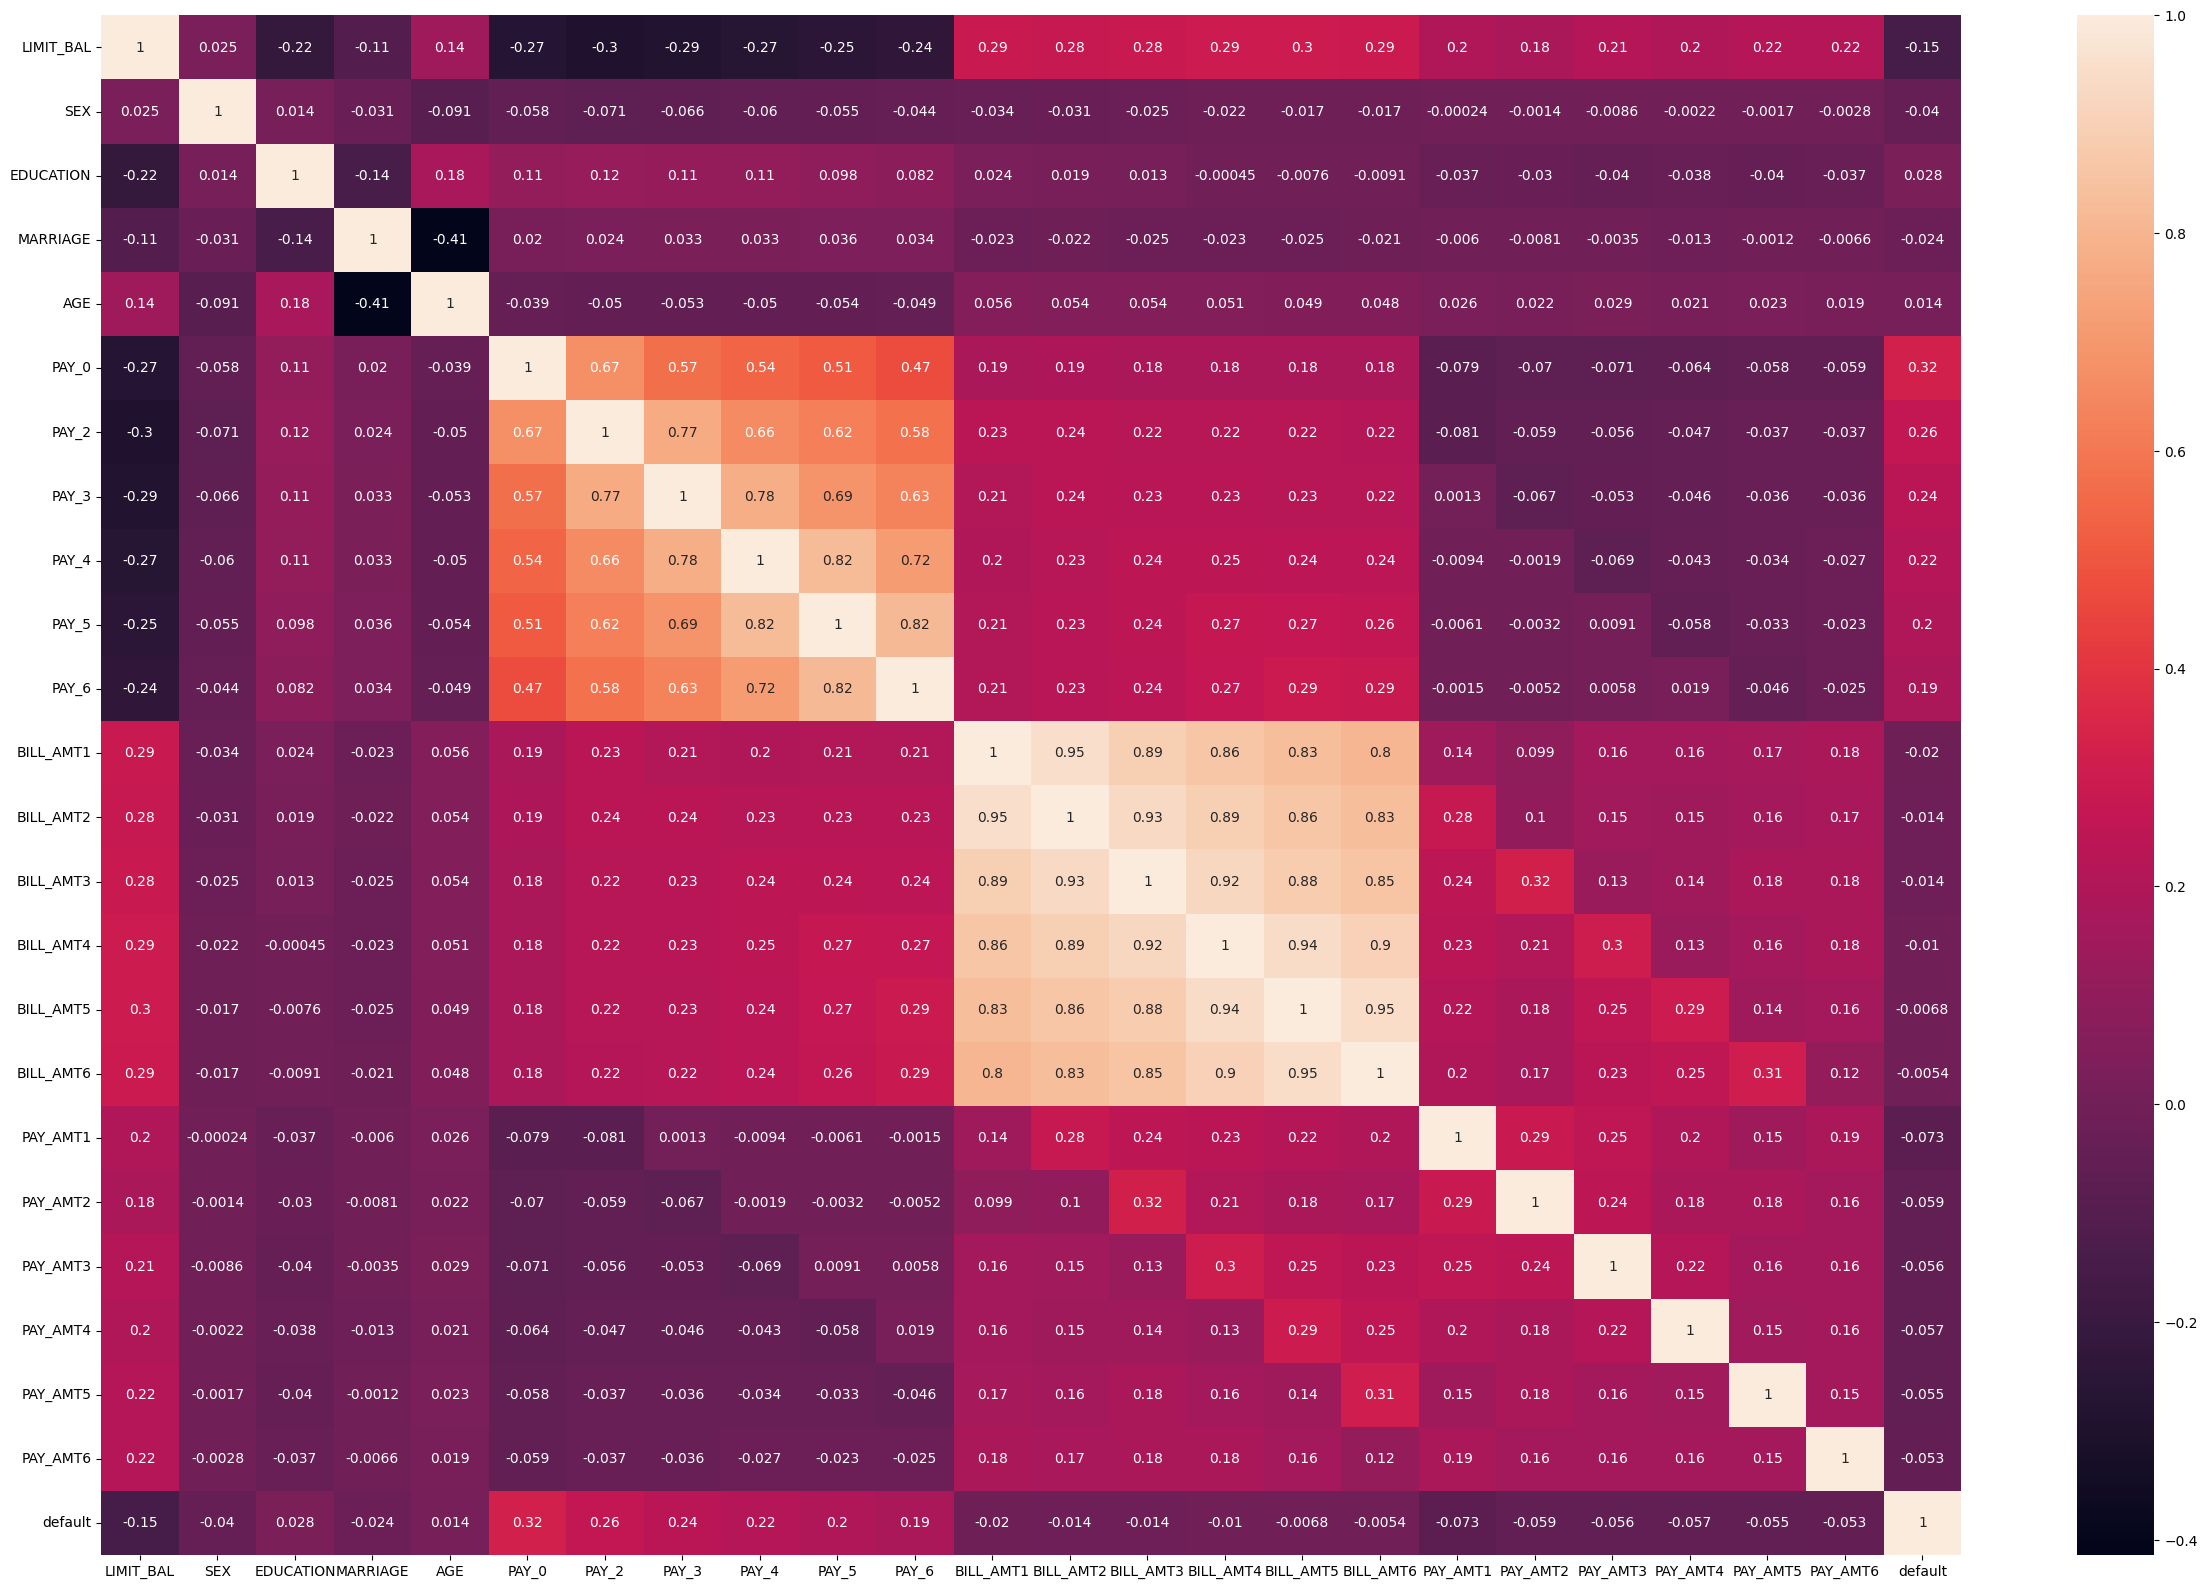

In [3]:
plt.subplots(figsize=(30,20))
sns.heatmap(df.corr(), annot=True)
plt.show()

According to the illustrated HeatMap, we can observe that there is a high correlation between **PAY_0** and **default**

# **Splitting data**

In [4]:
X = df.drop('default', axis=1)
y = df['default']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# DecisionTreeClassifier

In [6]:
param_grid = {
    'max_depth': [5],
    'min_samples_leaf': [4], 
    'min_samples_split': [2]
}

# param_grid = {
#     'max_depth': [None, 5, 10, 15],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

dt = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Наилучшие параметры:", best_params)

dt_model = DecisionTreeClassifier(**best_params)
dt_model.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Наилучшие параметры: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}


DecisionTreeClassifier(max_depth=5, min_samples_leaf=4)

**Evaluation - ROC AUC & Feature Importance**

In [7]:
y_train_pred = dt_model.predict_proba(X_train)[:, 1]
y_test_pred_dt = dt_model.predict_proba(X_test)[:, 1]

# ROC AUC for train
roc_auc_train_dt = roc_auc_score(y_train, y_train_pred)
print("ROC AUC for train:", roc_auc_train_dt)

# ROC AUC for test
roc_auc_test_dt = roc_auc_score(y_test, y_test_pred_dt)
print("ROC AUC for test:", roc_auc_test_dt)

ROC AUC for train: 0.7638122250922575
ROC AUC for test: 0.7527954441568462


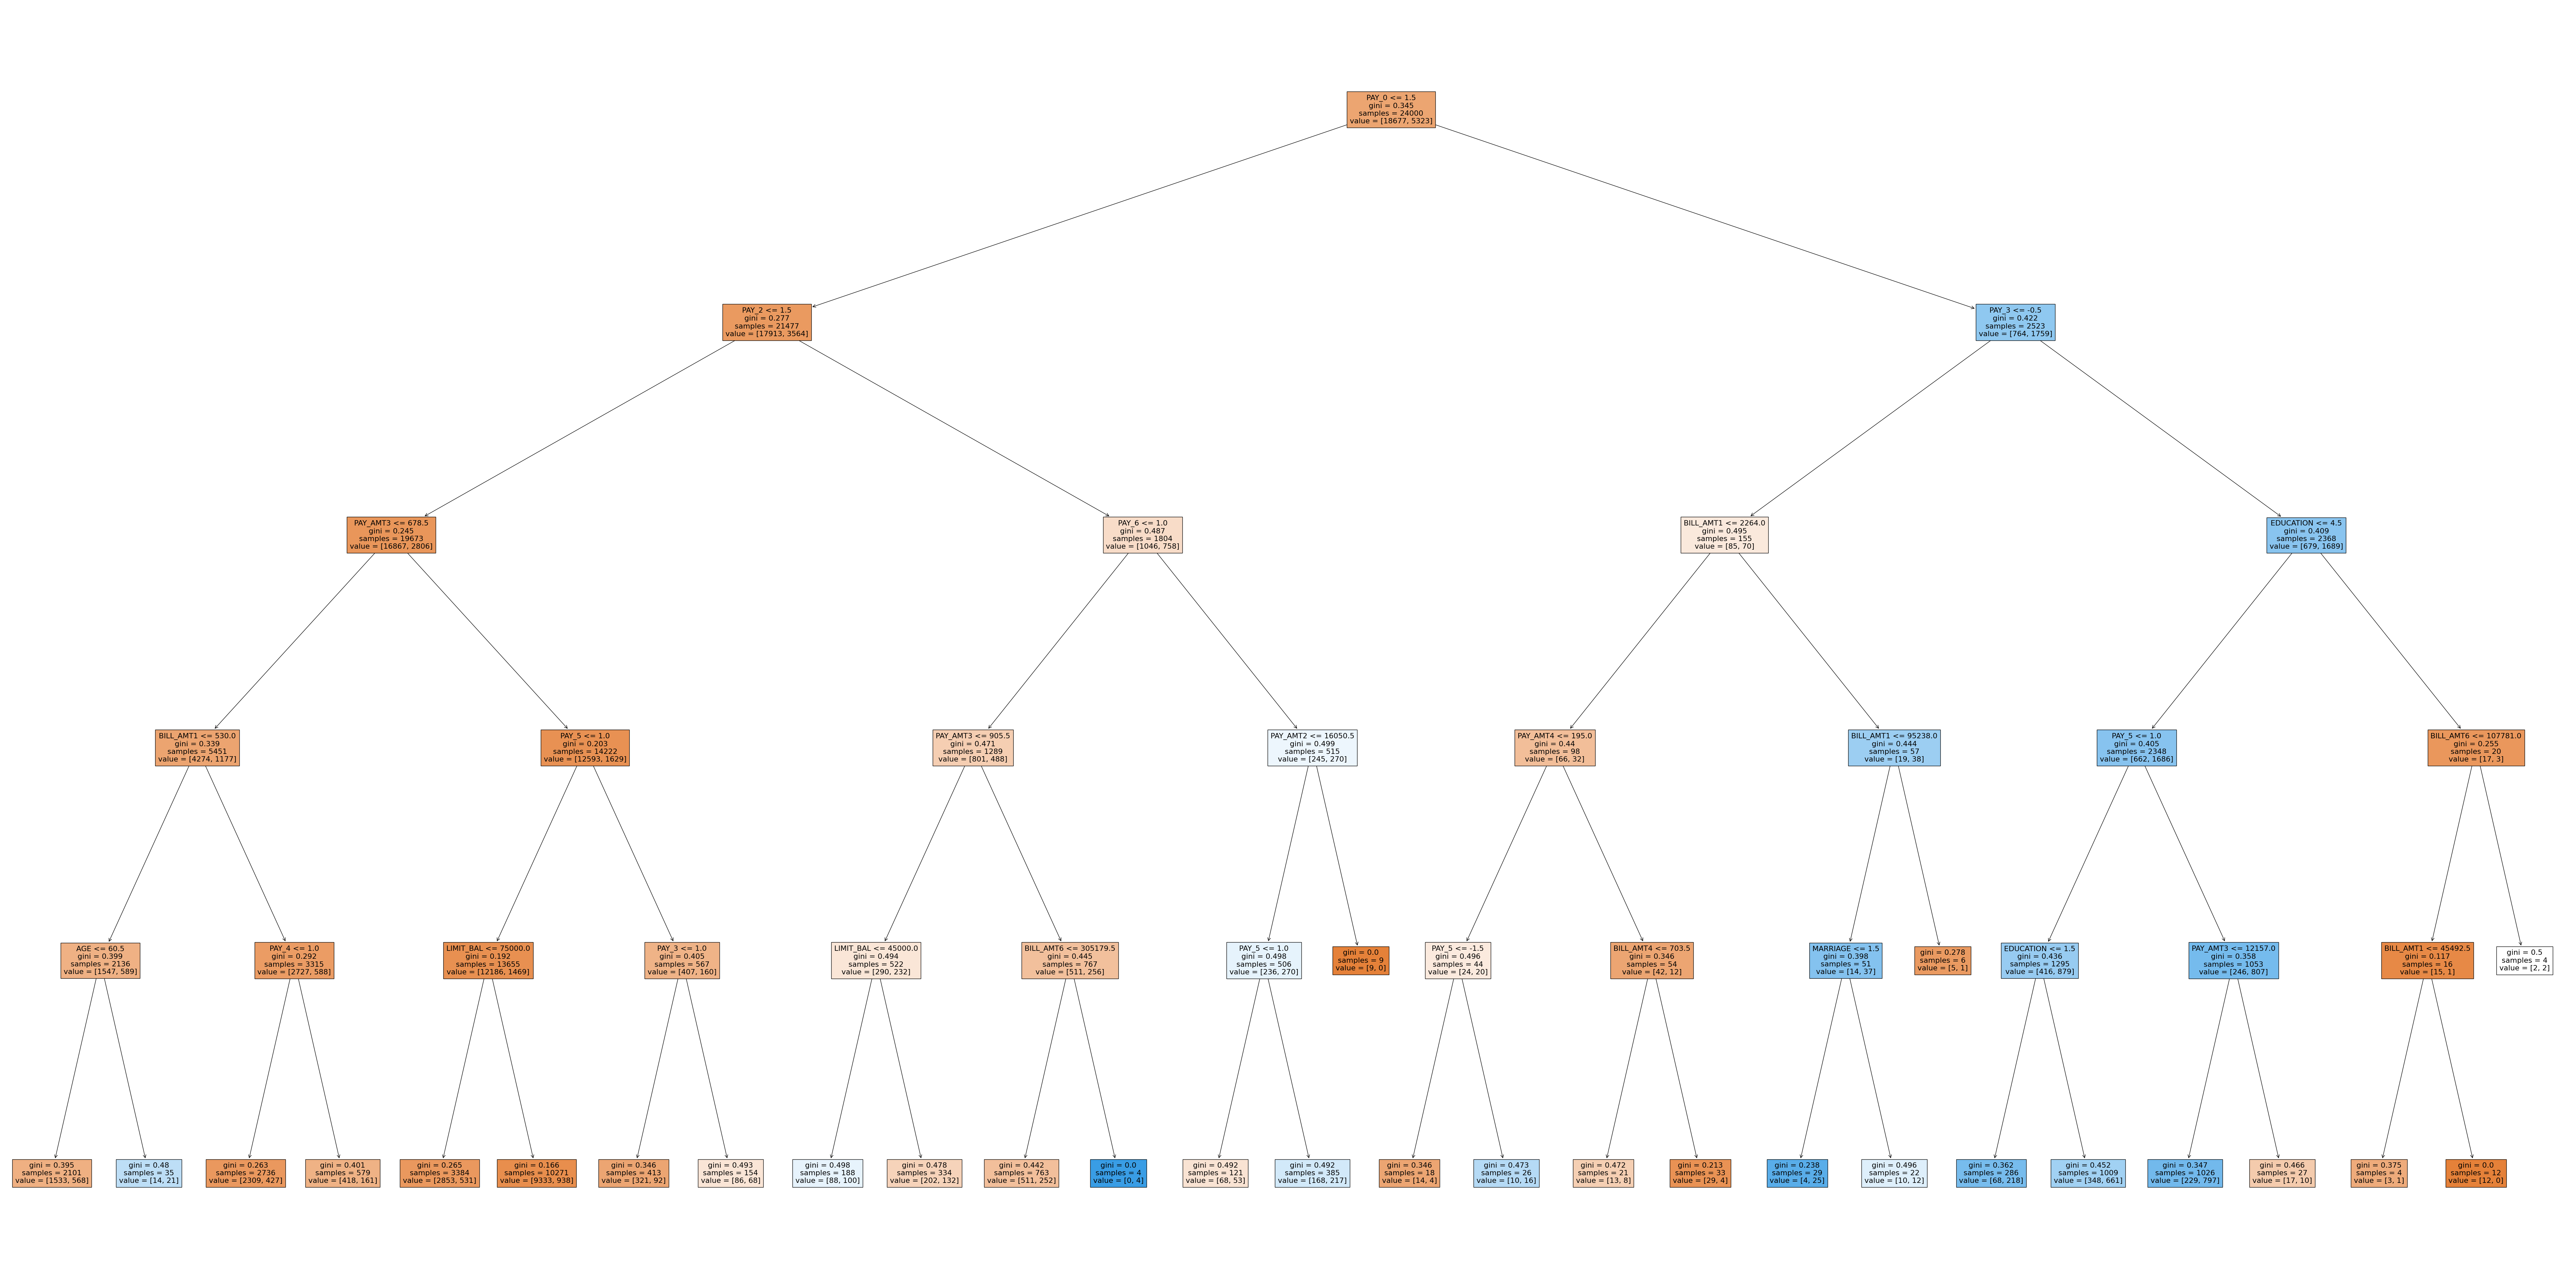

      feature  importance
5       PAY_0    0.692305
6       PAY_2    0.138305
19   PAY_AMT3    0.052863
9       PAY_5    0.026242
11  BILL_AMT1    0.020214
7       PAY_3    0.016655
0   LIMIT_BAL    0.014340
2   EDUCATION    0.009732
10      PAY_6    0.008486
8       PAY_4    0.007728
4         AGE    0.004065
18   PAY_AMT2    0.002736
16  BILL_AMT6    0.002605
20   PAY_AMT4    0.001422
3    MARRIAGE    0.001363
14  BILL_AMT4    0.000941
1         SEX    0.000000
12  BILL_AMT2    0.000000
13  BILL_AMT3    0.000000
15  BILL_AMT5    0.000000
17   PAY_AMT1    0.000000
21   PAY_AMT5    0.000000
22   PAY_AMT6    0.000000


In [8]:
plt.figure(figsize=(100, 50))
plot_tree(dt_model, filled=True, feature_names=X.columns.tolist())
plt.show()

feature_importance = pd.DataFrame({"feature": X.columns, "importance": dt_model.feature_importances_})
feature_importance = feature_importance.sort_values(by="importance", ascending=False)
print(feature_importance)

# RandomForestClassifier

In [9]:
param_grid = {
 'max_depth': [8],
 'min_samples_leaf': [1],
 'min_samples_split': [10],
 'n_estimators': [100]
}

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [2, 4, 6, 8, 10],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Наилучшие параметры:", best_params)

rf_model = RandomForestClassifier(**best_params)
rf_model.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Наилучшие параметры: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


RandomForestClassifier(max_depth=8, min_samples_split=10)

**Evaluation - ROC AUC & Feature Importance**

In [10]:
y_train_pred = rf_model.predict_proba(X_train)[:, 1]
y_test_pred_rf = rf_model.predict_proba(X_test)[:, 1]

# ROC AUC for train
roc_auc_train_rf = roc_auc_score(y_train, y_train_pred)
print("ROC AUC for train:", roc_auc_train_rf)

# ROC AUC for test
roc_auc_test_rf = roc_auc_score(y_test, y_test_pred_rf)
print("ROC AUC for test:", roc_auc_test_rf)

ROC AUC for train: 0.8135671273168329
ROC AUC for test: 0.7761420928818851


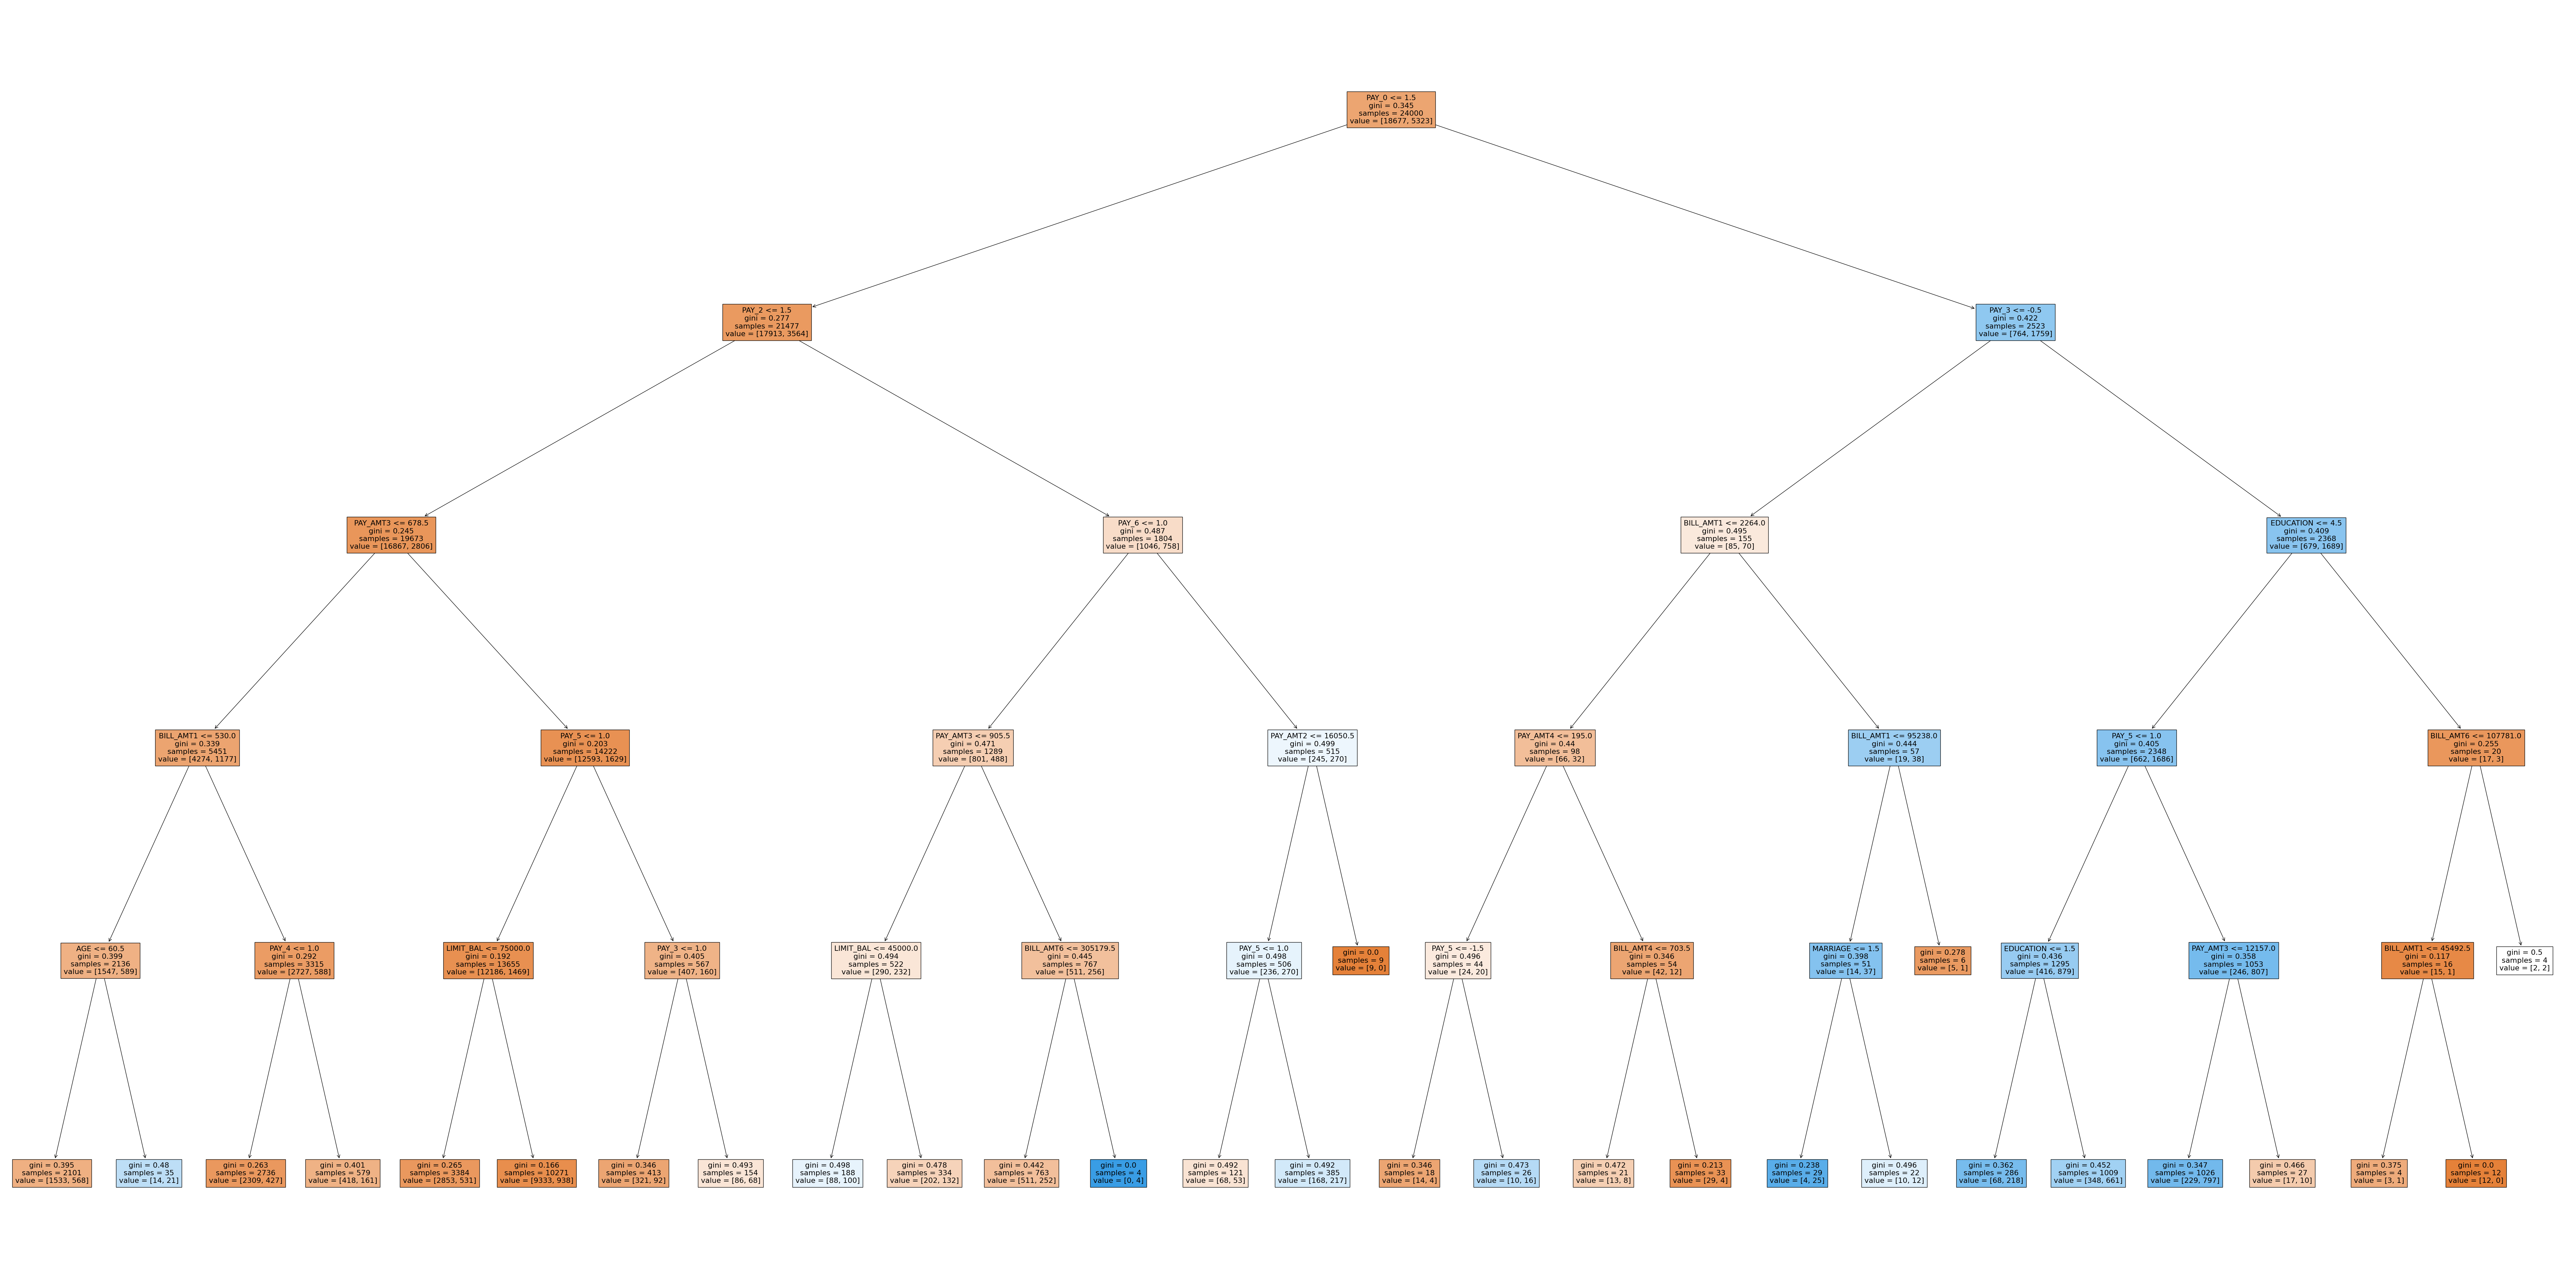

      feature  importance
5       PAY_0    0.313773
6       PAY_2    0.141574
7       PAY_3    0.069144
8       PAY_4    0.064063
9       PAY_5    0.048406
17   PAY_AMT1    0.044290
10      PAY_6    0.038808
0   LIMIT_BAL    0.031478
18   PAY_AMT2    0.026171
11  BILL_AMT1    0.025982
19   PAY_AMT3    0.024254
12  BILL_AMT2    0.021936
13  BILL_AMT3    0.020383
15  BILL_AMT5    0.018922
20   PAY_AMT4    0.018623
22   PAY_AMT6    0.018411
14  BILL_AMT4    0.016887
16  BILL_AMT6    0.015992
4         AGE    0.015170
21   PAY_AMT5    0.014865
2   EDUCATION    0.005769
3    MARRIAGE    0.003275
1         SEX    0.001822


In [11]:
plt.figure(figsize=(100, 50))
plot_tree(dt_model, filled=True, feature_names=X.columns.tolist())
plt.show()

feature_importance = pd.DataFrame({"feature": X.columns, "importance": rf_model.feature_importances_})
feature_importance = feature_importance.sort_values(by="importance", ascending=False)
print(feature_importance)

# XGBOOST

In [12]:
param_grid = {
    'n_estimators': [300],
    'max_depth': [3],
    'learning_rate': [0.001],
}

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [3, 5, 7],
#     'learning_rate': [0.1, 0.01, 0.001],
# }

xgb = XGBClassifier()

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Наилучшие параметры:", best_params)

xgb_model = XGBClassifier(**best_params)
xgb_model.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Наилучшие параметры: {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 300}


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

**Evaluation - ROC AUC & Feature Importance**

In [13]:
y_train_pred = xgb_model.predict_proba(X_train)[:, 1]
y_test_pred_xgb = xgb_model.predict_proba(X_test)[:, 1]

# ROC AUC for train
roc_auc_train_xgb = roc_auc_score(y_train, y_train_pred)
print("ROC AUC for train:", roc_auc_train_xgb)

# ROC AUC for test
roc_auc_test_xgb = roc_auc_score(y_test, y_test_pred_xgb)
print("ROC AUC for test:", roc_auc_test_xgb)

ROC AUC for train: 0.7560370680982862
ROC AUC for test: 0.7501859350399762


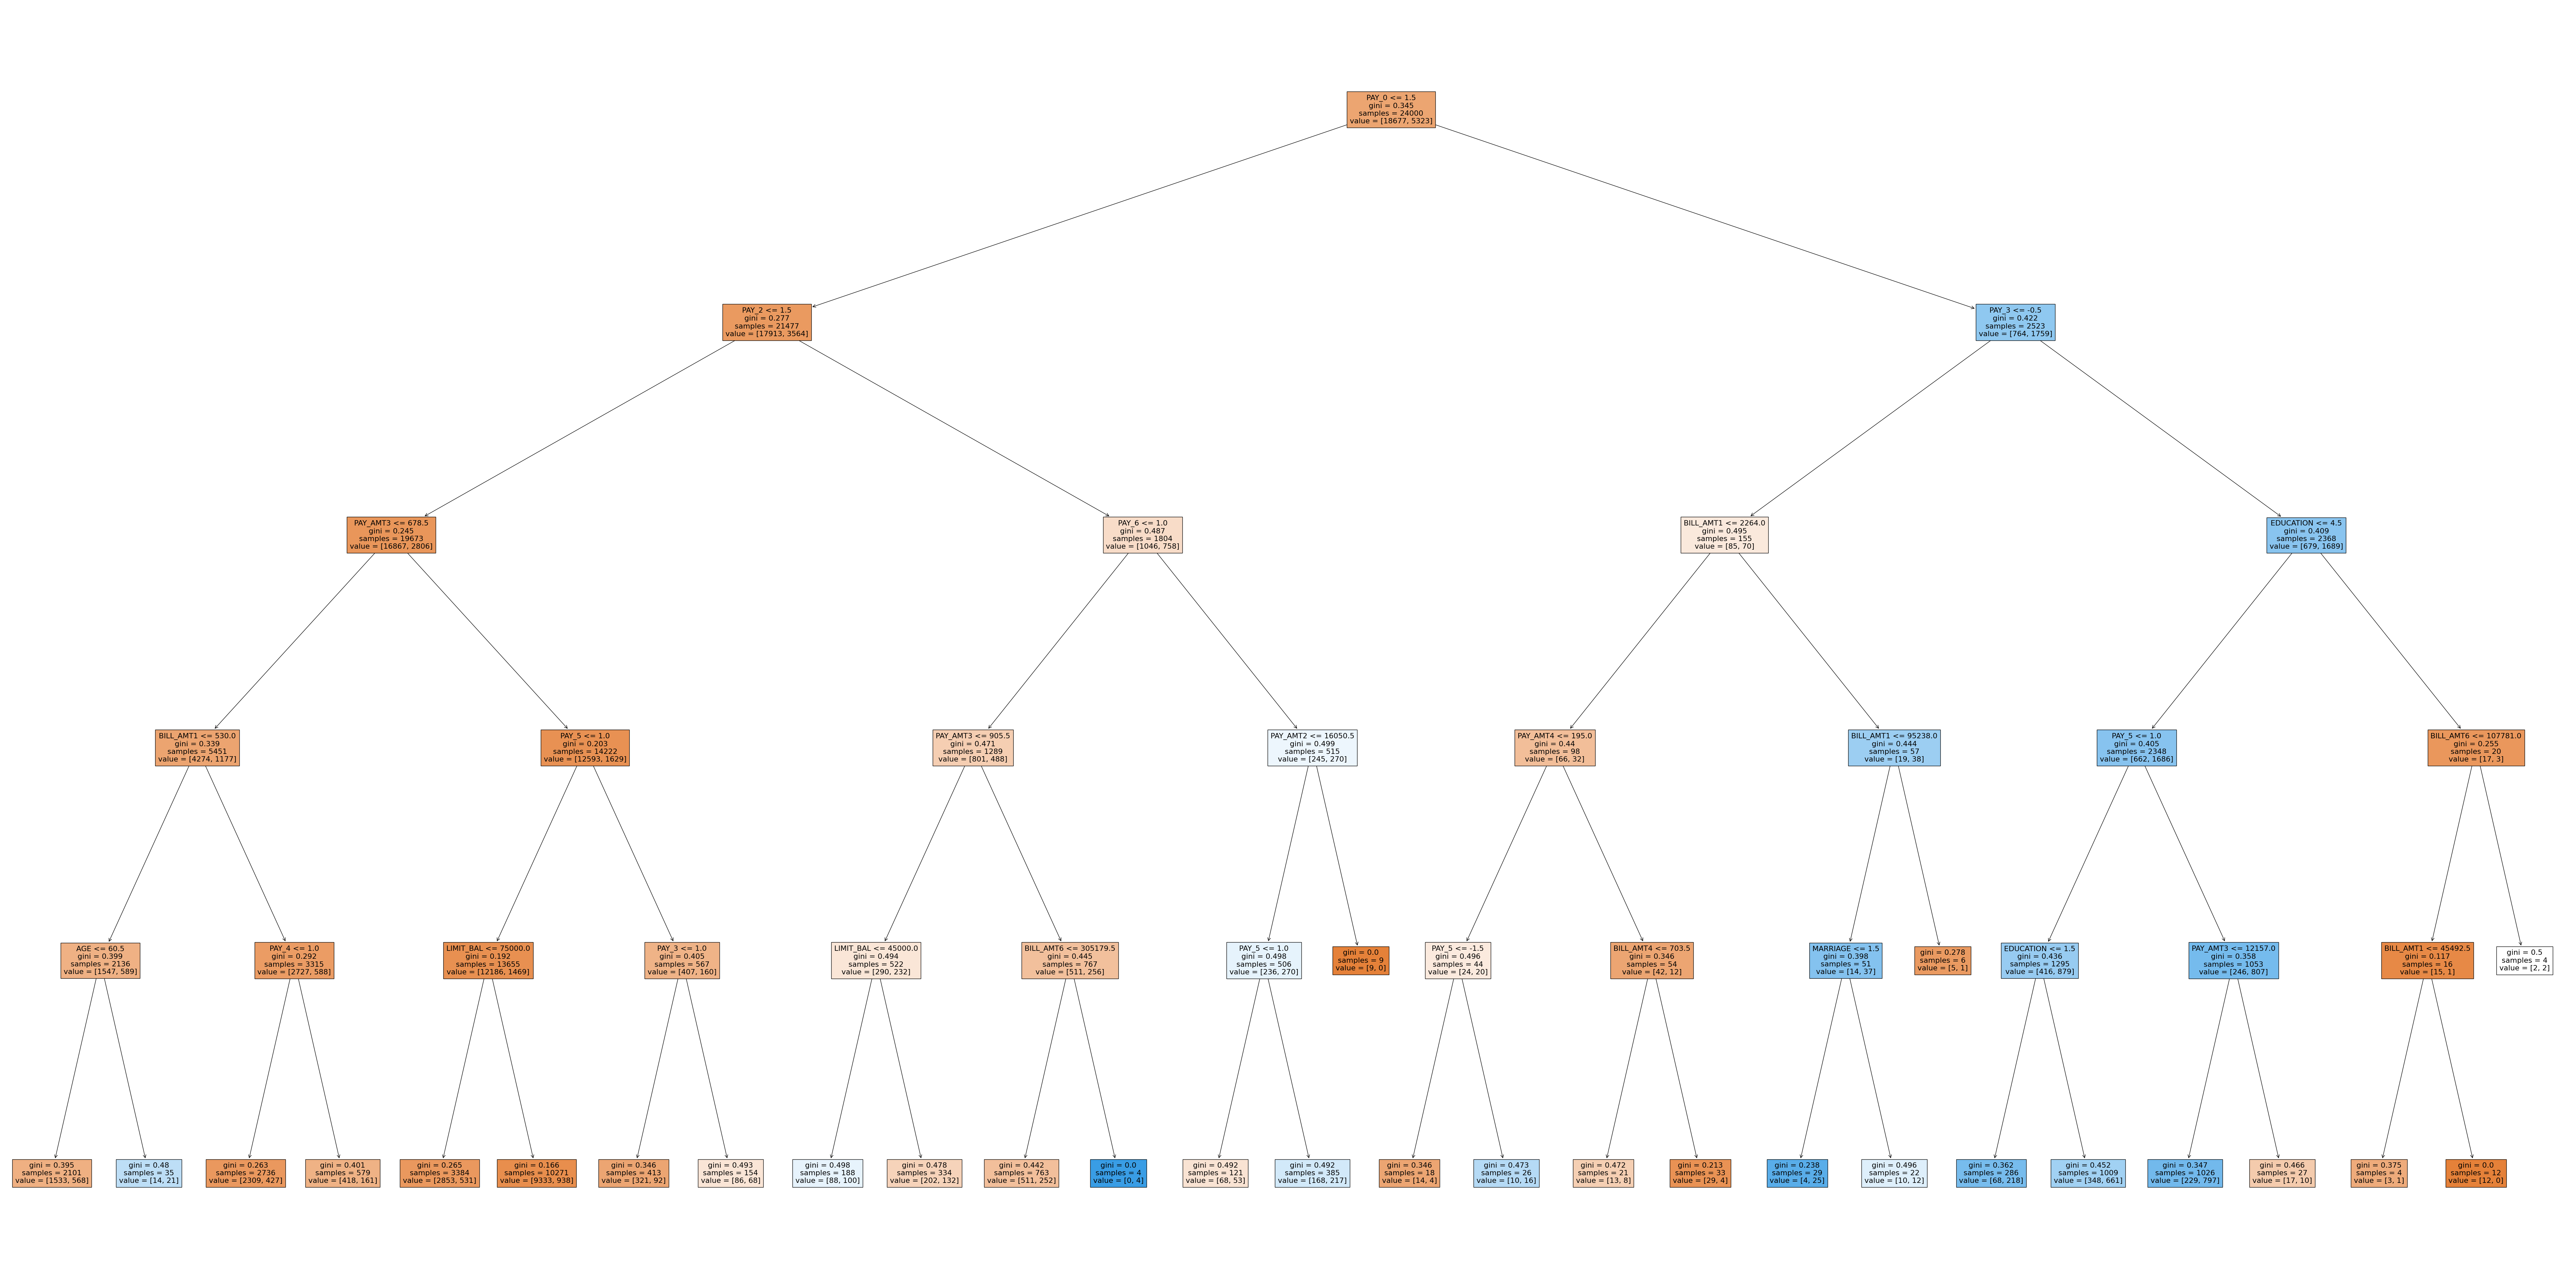

      feature  importance
5       PAY_0    0.709452
6       PAY_2    0.143812
18   PAY_AMT2    0.043372
19   PAY_AMT3    0.039467
20   PAY_AMT4    0.022230
7       PAY_3    0.010762
10      PAY_6    0.009575
9       PAY_5    0.008367
2   EDUCATION    0.007468
11  BILL_AMT1    0.005495
15  BILL_AMT5    0.000000
21   PAY_AMT5    0.000000
17   PAY_AMT1    0.000000
16  BILL_AMT6    0.000000
0   LIMIT_BAL    0.000000
14  BILL_AMT4    0.000000
13  BILL_AMT3    0.000000
12  BILL_AMT2    0.000000
1         SEX    0.000000
8       PAY_4    0.000000
4         AGE    0.000000
3    MARRIAGE    0.000000
22   PAY_AMT6    0.000000


In [14]:
plt.figure(figsize=(100, 50))
plot_tree(dt_model, filled=True, feature_names=X.columns.tolist())
plt.show()

feature_importance = pd.DataFrame({"feature": X.columns, "importance": xgb_model.feature_importances_})
feature_importance = feature_importance.sort_values(by="importance", ascending=False)
print(feature_importance)

# Model comparison

In [15]:
df_comparison = pd.DataFrame({
    'Model': ['DecisionTree', 'RandomForest', 'XGBoost'],
    'ROC_AUC train': [roc_auc_train_dt, roc_auc_train_rf, roc_auc_train_xgb],
    'ROC_AUC test': [roc_auc_test_dt, roc_auc_test_rf, roc_auc_test_xgb],
    'Difference': [roc_auc_train_dt - roc_auc_test_dt, roc_auc_train_rf - roc_auc_test_rf, roc_auc_train_xgb - roc_auc_test_xgb]
})

df_comparison

Model  ROC_AUC train  ROC_AUC test  Difference
0  DecisionTree       0.763812      0.752795    0.011017
1  RandomForest       0.813567      0.776142    0.037425
2       XGBoost       0.756037      0.750186    0.005851

According to the difference between ROC_AUC scores for training and testing for different models, we can observe that **XGBoost** model has the lowest score. It indicates good generalization to new, unseen data, while a large difference suggest overfitting or underfitting.

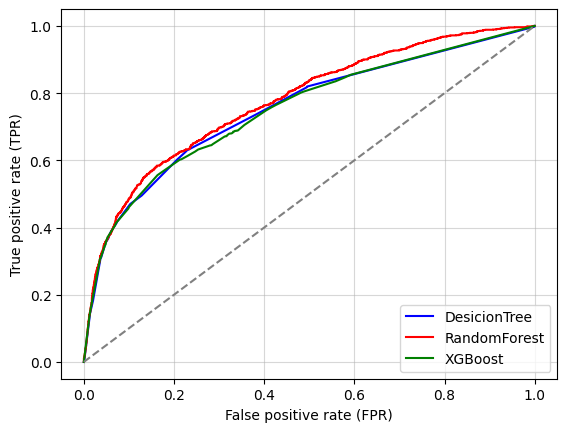

In [17]:
fpr_dt, tpr_dt, thresholds = roc_curve(y_true=y_test, y_score=y_test_pred_dt)
fpr_rf, tpr_rf, thresholds = roc_curve(y_true=y_test, y_score=y_test_pred_rf)
fpr_xgb, tpr_xgb, thresholds = roc_curve(y_true=y_test, y_score=y_test_pred_xgb)

roc_auc = auc(x=fpr_dt, y=tpr_dt)
roc_auc = auc(x=fpr_rf, y=tpr_rf)
roc_auc = auc(x=fpr_xgb, y=tpr_xgb)

plt.plot(fpr_dt,tpr_dt, color='blue', label=f'DesicionTree')
plt.plot(fpr_rf,tpr_rf, color='red', label=f'RandomForest')
plt.plot(fpr_xgb,tpr_xgb, color='green', label=f'XGBoost')

plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.legend(loc = 'lower right')
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.grid(alpha=0.5)

# Feature Importance Explanation

1. **PAY_0**: Repayment status in September, 2005. This feature has the highest importance in both models, indicating that the repayment status in September is a crucial predictor for determining whether the client will default or not. A high importance suggests that clients with delayed payments or payment defaults in September are more likely to default in the next month. One of the reasons could be that in Taiwan most credit takers make most of the money during the spring and the summer and if they are unable to repay at the start of autumn it is highly likely they will default. 

2. **PAY_2, PAY_3, PAY_4, PAY_5, PAY_6**: Repayment status in previous months. The repayment status in previous months also has high importance in both models. This suggests that the payment behavior history significantly influences the likelihood of defaulting in the next month. Clients with a consistent history of delayed payments are more likely to default. Repayment status is important because it tracks the ability of the client to provide payments. 

3. **PAY_AMT1, PAY_AMT2, PAY_AMT3, PAY_AMT4, PAY_AMT5, PAY_AMT6**: Amount of previous payment (NT dollar) in different years. Seems to have little effect on the probability of default. A possible explanation is the fact that if a client is able to repay at a certain period does not indicate an ability to repay at a future period. For example a client could have spent all his savings to repay the credit and thereby will be unable to repay at a future date. 

4. **Age, education and marriage** Have little effect on the probability of a client default, This information looks anomalous and could be caused by a relationship between the different factors and external factors. For example, it is possible that people with higher age generally borrow less and those that do have financial troubles which leads to a default. Furthermore, there could be different correlations between the factors.

5. **Limit bal** Obviously the more clients borrow the more trouble they will have at repaying the credit. So the risk of a default is higher. However, usually large credits are not given to risky clients and therefore the risk of the default is reduced and large sums are checked more thoroughly. Overall this leads to a mediocre impact of credit balance on the probability of default.  